In [2]:
import discretisedfield as df
import micromagneticdata as md
import numpy as np

In [3]:
data = md.Data(name='sky_drive', dirname='C:\simulation_data\磁各向异性梯度驱动斯格明子2')

In [6]:
obj = data[0][100]
obj

Field(Mesh(Region(pmin=[0.0, -2e-08, -2e-10], pmax=[5e-07, 2e-08, 2e-10], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[500, 40, 1]), nvdim=3, vdims: (x, y, z), unit=A/m)

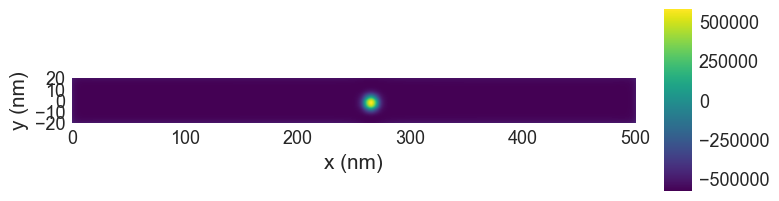

In [4]:
obj.mpl()

In [5]:
from cal_r import find_roots
def outline(obj):
    # 1. 确定坐标范围
    xmin = obj.mesh.region.pmin[0]
    xmax = obj.mesh.region.pmax[0]
    ymin = obj.mesh.region.pmin[1]
    ymax = obj.mesh.region.pmax[1]
    
    Y = np.linspace(ymin,ymax,obj.mesh.n[1])

    # 储存斯格明子的坐标集
    x_sets = []
    y_sets = []

    for y in Y:
        line = obj.line(p1=(xmin,y),p2=(xmax,y))
        v = line.data['v'].values
        x = line.data['x'].values
        zero_points = find_roots(x,v)
        
        for x in zero_points:
            x_sets.append(x)
            y_sets.append(y)

    x_center = sum(x_sets)/len(x_sets)
    y_center = sum(y_sets)/len(y_sets)
    
    # 1. 把所有的坐标减去中心坐标
    for i in range(len(x_sets)):
        x_sets[i] -= x_center
        y_sets[i] -= y_center

    # 2. 把坐标转换为极坐标
    from math import sqrt, atan2
    r_sets = []
    theta_sets = []

    for i in range(len(x_sets)):
        r = sqrt(x_sets[i]**2 + y_sets[i]**2)
        theta = atan2(y_sets[i],x_sets[i])
        r_sets.append(r)
        theta_sets.append(theta)

    # 3. 排序
    zipped = zip(theta_sets,r_sets)
    sorted_zipped = sorted(zipped,key=lambda x: x[0])
    sorted_theta, sorted_r = zip(*sorted_zipped)
    
    # 7. 极坐标转换为直角坐标
    from math import sin, cos
    x_sorted = []
    y_sorted = []
    for i in range(len(sorted_theta)):
        x = sorted_r[i] * cos(sorted_theta[i])
        y = sorted_r[i] * sin(sorted_theta[i])
        x_sorted.append(x)
        y_sorted.append(y)

    # 8. 把所有坐标加上中心坐标
    for i in range(len(x_sorted)):
        x_sorted[i] += x_center
        y_sorted[i] += y_center
    
    return x_sorted, y_sorted, x_center, y_center

x_sets, y_sets, x_center, y_center = outline(obj)

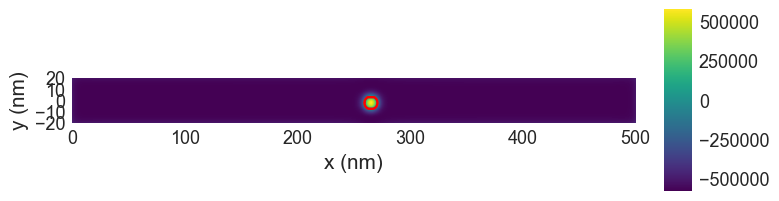

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
obj.mpl(ax=ax)

# 需要放大一下零点坐标，以适应obj.mpl
x_zero_points_modified = []
y_zero_points_modified = []
for i in range(len(x_sets)):
    y_zero_points_modified.append(y_sets[i]*1e9) 
    x_zero_points_modified.append(x_sets[i]*1e9)

ax.plot(x_zero_points_modified,y_zero_points_modified,c='red')
#ax.scatter(x_center*1e9,y_center*1e9,c='black')

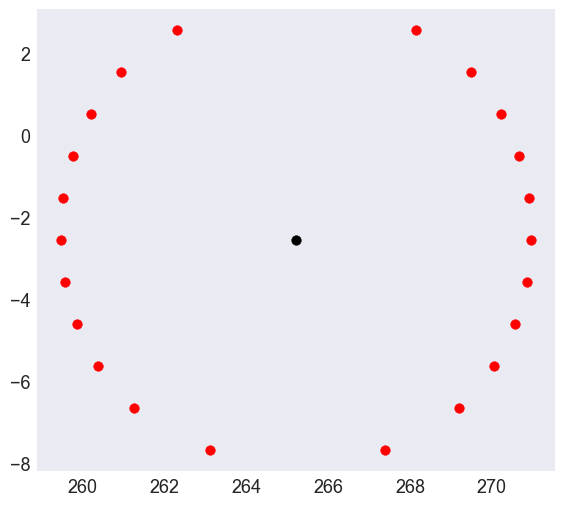

In [8]:
plt.scatter(x_zero_points_modified,y_zero_points_modified,c='red')
plt.scatter(x_center*1e9,y_center*1e9,c='black')
plt.gca().set_aspect('equal', adjustable='box')

1. 把所有的坐标减去中心坐标
2. 把坐标转换为极坐标
3. 排序
4. 傅里叶变换
5. 滤波
6. 逆傅里叶变换
7. 把极坐标转换为直角坐标
8. 把所有坐标加上中心坐标

In [9]:
# 1. 把所有的坐标减去中心坐标
for i in range(len(x_sets)):
    x_sets[i] -= x_center
    y_sets[i] -= y_center

# 2. 把坐标转换为极坐标
from math import sqrt, atan2
r_sets = []
theta_sets = []

for i in range(len(x_sets)):
    r = sqrt(x_sets[i]**2 + y_sets[i]**2)
    theta = atan2(y_sets[i],x_sets[i])
    r_sets.append(r)
    theta_sets.append(theta)

# 3. 排序
zipped = zip(theta_sets,r_sets)
sorted_zipped = sorted(zipped,key=lambda x: x[0])
sorted_theta, sorted_r = zip(*sorted_zipped)

# 4. 傅里叶变换
from scipy.fft import fft
r_fft = fft(sorted_r)

# 5. 滤波
from scipy.fft import ifft
from cal_r import band_pass_filter
# 获取频率轴的值
N = len(sorted_r)
T = sorted_theta[1] - sorted_theta[0]  # 采样间隔
freq = np.fft.fftfreq(N, T)
bpf_result = band_pass_filter(r_fft, freq, cutoff_low=0, cutoff_high=10)  # 假定截止频率为0Hz到1Hz

# 6. 逆傅里叶变换
bpf_r = np.real(ifft(bpf_result))# 对每种滤波结果进行逆傅里叶变换以回到时域

# 7. 极坐标转换为直角坐标
from math import sin, cos
x_sorted = []
y_sorted = []
for i in range(len(sorted_theta)):
    x = bpf_r[i] * cos(sorted_theta[i])
    y = bpf_r[i] * sin(sorted_theta[i])
    x_sorted.append(x)
    y_sorted.append(y)

# 8. 把所有坐标加上中心坐标
for i in range(len(x_sorted)):
    x_sorted[i] += x_center
    y_sorted[i] += y_center

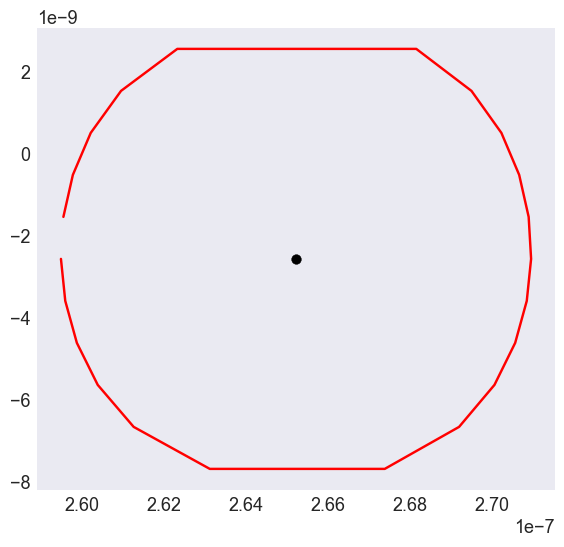

In [11]:
plt.plot(x_sorted,y_sorted,c='red')
plt.scatter(x_center,y_center,c='black')
plt.gca().set_aspect('equal', adjustable='box')